# the Big Idea of TablaSet: indexed datasets with projections

It may sometimes seems natural to represent many parameters as elements of some kind of dataset, for example a dict of arrays.

A TablaSet is a dataset indexed with keys like a dict of TablArrays, but furthered by new principles:

1. A TablaSet internally tracks a master shape you would get as a result if all elements broadcast together.

2. New elements cannot be added unless they are broadcast-compatible with all other elements. (Otherwise the master shape would become undefined.)

3. You can always query a TablaSet using projections, which means that indexing works with respect to the master shape rather than the element shapes.

Projections make degeneracy transparent - you still need to know the master shape to call for a projection, but you don't need to know the shape of each element. In other words you don't need to know an element's degeneracy in order to call a projection.

So projections have the most obvious value in systems where tabular degeneracy is changeable. But even when that's not the case, blinding library code to degeneracy in applications can still sometimes be incredibly useful.

## Compared to a database

There is application overlap between a TablaSet and a database such as SQL or pandas.DataFrame. Here are some distinctions:

* The broadcast-compatibility of TablaSet makes it a more specific type of database (useful in physics and engineering and similar applications). Degeneracy is allowed but TablaSet cannot deal with ragged or irregular tables and so a database has a more general purpose.
* Slicing is fundamentally faster than query. If the dataset is regular then TablaSet can lead to faster operation. 
* Fall back on a database or Pandas if the tabular shapes are actually ragged or irregular. Slicing is impossible in such systems.

## An example, reminiscent of B field around a wire

In [1]:
import numpy as np
import tablarray as ta
from matplotlib import pyplot as plt


# inputs
I = ta.TablArray([0, 0, -10],cdim=1)
x = ta.TablArray(np.linspace(-2, 2, 6).reshape(6, 1, 1), cdim=0)
y = ta.TablArray(np.linspace(1.5, 2.5, 3).reshape(3, 1), cdim=0)
z = ta.TablArray(np.linspace(-1, 1, 2), cdim=0)
# calculations
v = ta.stack_bcast((x.cell, y, 0), axis=0)
r = ta.sqrt(ta.sum(v.cell**2))
B = ta.cross(I, v)/r**3
# a TablaSet, mostly just for pretty tabular print for now
set1 = ta.TablaSet(x=x, y=y, z=z, r=r, v=v, B=B)
print(set1)

           | x           | y          | z           | r          | v          | B             |
-----------+-------------+------------+-------------+------------+------------+---------------+
 [0, 0, 0] | -2.00000000 | 1.50000000 | -1.00000000 | 2.50000000 | [-2.   1.5 | [0.96 1.28    |
           |             |            |             |            |   0. ]     |  0.  ]        |
-----------+-------------+------------+-------------+------------+------------+---------------+
 [0, 0, 1] |             |            | 1.00000000  |            |            |               |
-----------+-------------+------------+-------------+------------+------------+---------------+
 [0, 1, 0] |             | 2.00000000 |             | 2.82842712 | [-2.  2.   | [0.88388348   |
           |             |            |             |            |   0.]      |  0.88388348   |
           |             |            |             |            |            |  0.        ]  |
-----------+-------------+------------+-

Text(0.5, 0, 'z')

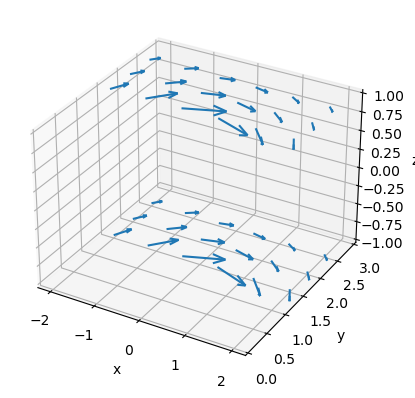

In [2]:
ta.quiver3d(x, y, z, B, length=.2)
plt.ylim([0, 3])
plt.xlabel('x')
plt.ylabel('y')
ax = plt.gca()
ax.set_zlabel('z')

Here's an example of projecting set1 into a new set at only a specific value of z.

In [3]:
set_z1 = set1['x', 'y', 'z', 'B', :, :, 0]
print(set_z1)

        | x           | y          | z      | B             |
--------+-------------+------------+--------+---------------+
 [0, 0] | -2.00000000 | 1.50000000 | |-1.0| | [0.96 1.28    |
        |             |            |        |  0.  ]        |
--------+-------------+------------+--------+---------------+
 [0, 1] |             | 2.00000000 |        | [0.88388348   |
        |             |            |        |  0.88388348   |
        |             |            |        |  0.        ]  |
--------+-------------+------------+--------+---------------+
 [0, 2] |             | 2.50000000 |        | [0.76182323   |
        |             |            |        |  0.60945858   |
        |             |            |        |  0.        ]  |
--------+-------------+------------+--------+---------------+
 [1, 0] | -1.20000000 |            |        | [2.11617564   |
        |             |            |        |  1.69294051   |
        |             |            |        |  0.        ]  |
--------

(-1.0, 0.0)

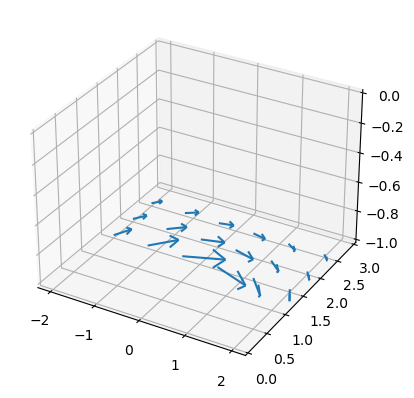

In [4]:
ta.quiver3d(set_z1, 'x', 'y', 'z', 'B', length=0.2)
plt.ylim([0, 3])
ax = plt.gca()
ax.set_zlim([-1, 0])